In [1]:
import numpy as np
from six.moves import cPickle as pickle
from scipy import misc
import scipy.io as sio
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import random
import os
%matplotlib inline
print "Done"

Done


In [2]:
#folder1="train"
#raw_training_data = sio.loadmat(folder1 + "_data")[folder1 + '_dataset']

folder2="train"
raw_extra_data = sio.loadmat(folder2 + "_data")[folder2 + '_dataset']
print "Done"

Done


In [3]:
raw_training_data = raw_extra_data

In [4]:
train_image_names, train_labels, train_bboxes, train_n_bboxes = raw_training_data['names'], raw_training_data['labels'], raw_training_data['bbox'], raw_training_data['length']
print train_image_names.shape
print train_labels.shape
print train_bboxes.shape
print train_n_bboxes.shape
TRAIN_DATASET_SIZE=train_labels.shape[1]

#extra_image_names, extra_labels, extra_bboxes, extra_n_bboxes = raw_extra_data['names'], raw_extra_data['labels'], raw_extra_data['bbox'], raw_extra_data['length']
#print extra_image_names.shape
#print extra_labels.shape
#print extra_bboxes.shape
#print extra_n_bboxes.shape

(1, 33402)
(1, 33402)
(1, 33402)
(1, 33402)


In [5]:
train_image_names = train_image_names.reshape(train_image_names.shape[1])
train_labels = train_labels.reshape(train_labels.shape[1])
train_bboxes = train_bboxes.reshape(train_bboxes.shape[1])
train_n_bboxes = train_n_bboxes.reshape(train_n_bboxes.shape[1])

train_image_names = [item for sublist in train_image_names for item in sublist]
train_labels = [item for sublist in train_labels for item in sublist]
train_bboxes = [item for sublist in train_bboxes for item in sublist]
train_n_bboxes = [item for sublist in train_n_bboxes for item in sublist]
print "Done"

Done


In [6]:
# extra_image_names = extra_image_names.reshape(extra_image_names.shape[1])
# extra_labels = extra_labels.reshape(extra_labels.shape[1])
# extra_bboxes = extra_bboxes.reshape(extra_bboxes.shape[1])
# n_bboxes = extra_n_bboxes.reshape(extra_n_bboxes.shape[1])

# extra_image_names = [item for sublist in extra_image_names for item in sublist]
#extra_labels = [item for sublist in extra_labels for item in sublist]
#extra_bboxes = [item for sublist in extra_bboxes for item in sublist]
#n_bboxes = [item for sublist in n_bboxes for item in sublist]
#print "Done"

[1, 9]
[1, 6, 9]


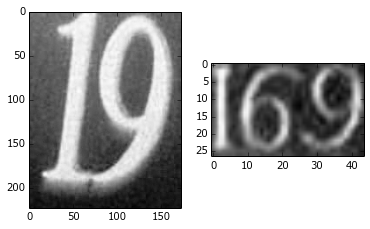

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)

# display the first and the last image and labels for the training dataset
img = misc.imread("./" + folder2 + "/" + str(train_image_names[0]), flatten=True)
aa, bb, cc, dd = train_bboxes[0]
img = img[aa:bb, cc:dd]
ax1.imshow(img, cmap=plt.cm.Greys)
print list(train_labels[0])

id = 33401
img = misc.imread("./" + folder2 + "/" + str(train_image_names[id]), flatten=True)
aa, bb, cc, dd = train_bboxes[id]
img = img[aa:bb, cc:dd]
ax2.imshow(img, cmap=plt.cm.Greys)
print list(train_labels[id])

[3, 4, 2] Shape: (45, 39)
./train/1106.png
# of digits: [2]
[3, 9] Shape: (39, 29)


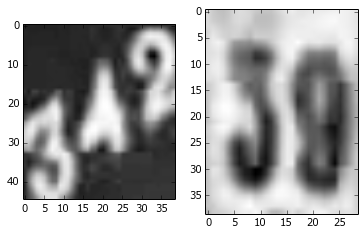

In [8]:
# display first and last image of the extra dataset
f, (ax1, ax2) = plt.subplots(1, 2)

id = 3402
# display the first and the last image and labels for the training dataset
img = misc.imread("./" + folder2 + "/" + str(train_image_names[id]), flatten=True)
aa, bb, cc, dd = train_bboxes[id]
img = img[aa:bb, cc:dd]
ax1.imshow(img, cmap=plt.cm.Greys)
print list(train_labels[id]), "Shape:", img.shape


id = 1105
img_name = "./" + folder2 + "/" + str(train_image_names[id])
print img_name
print "# of digits:", train_n_bboxes[id]
# display the first and the last image and labels for the training dataset
img = misc.imread(img_name, flatten=True)
aa, bb, cc, dd = train_bboxes[id]
img = img[aa:bb, cc:dd]
ax2.imshow(img, cmap=plt.cm.Greys)
print list(train_labels[id]), "Shape:", img.shape

In [9]:
MAX_IMAGE_SIZE=256
IMAGE_SIZE=56
N_CHANNELS=1
DATASET_SIZE = 33402
MAX_NUMBER_OF_LABELS=5
PIXEL_DEPTH=255
VALIDATION_DATASET_SIZE=500
TEST_DATASET_SIZE=500

In [10]:
def display_images_at_random(dataset, labels):
    # random.seed(1)
    
    f, axarr = plt.subplots(4, 3, figsize=(11,15))
    
    for i in range(4):
        for j in range(3):
            img_rand_index = random.randrange(0,dataset.shape[0])
            axarr[i, j].imshow(dataset[img_rand_index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys);
            axarr[i, j].set_title('Label: ' + str(labels[img_rand_index]) + "Id: " + str(img_rand_index))

    plt.show()

In [12]:
dataset_id = 0
dataset = np.zeros(shape=(DATASET_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS), dtype=np.float32)
labels = np.zeros(shape=(DATASET_SIZE, MAX_NUMBER_OF_LABELS), dtype=np.int8)
n_bboxes = []
selected_images = []

with tf.Session() as sess:
    for img_id in range(0,TRAIN_DATASET_SIZE):
        
        discard = False
        is_resized = False
        
        if (img_id < TRAIN_DATASET_SIZE):
            current_folder = folder2 # get from the extra dataset
        else:
            current_folder = folder2
            
        # get the image file name
        img_name = train_image_names[img_id]
        img_labels = list(train_labels[img_id])
        img_bboxes_number = train_n_bboxes[img_id]

        # if the image has more than digits, discard it
        if len(img_labels) > MAX_NUMBER_OF_LABELS:
            print "Discarding image:", img_name, "\tMore than:", MAX_NUMBER_OF_LABELS, "digits."
            continue
        
        # read the image from disk
        img = misc.imread("./" + current_folder + "/" + img_name, flatten=True)

        # read the bbox data
        aa, bb, cc, dd = train_bboxes[img_id]

        # crop the images to the bboxes
        img = img[aa:bb, cc:dd]
        
        # get the new image size
        img_h = img.shape[0]
        img_w = img.shape[1]
                
        # skip too large images
        if (img_h > 4 * IMAGE_SIZE) or (img_w > 6 * IMAGE_SIZE):
            print "Skipping image:", img_name, "\tShape rejected:", img_h, img_w
            continue
        
        # if the image is greater than IMAGE_SIZE, slowly resize it
        # until it fits the size
        if img_h > IMAGE_SIZE or img_w > IMAGE_SIZE:
            if img_w >= img_h:
                target_width = IMAGE_SIZE
                target_height = int(round((img_h * IMAGE_SIZE) / float(img_w)))
            else:
                target_height = IMAGE_SIZE
                target_width = int(round((img_w * IMAGE_SIZE) / float(img_h)))

            if (target_width < 10 or target_height < 10):
                print "--- Discarding image", img_name, "\nShape:",target_height, target_width, "---"
                continue
                
            img = misc.imresize(img,(target_height, target_width))
            is_resized = True
            
        if is_resized == True:
            print "Resizing image", img_name, "\nNew shape:",target_height, target_width
        
        # put the image to the defined size
        img = img.reshape(img.shape[0], img.shape[1], N_CHANNELS)
        img = tf.convert_to_tensor(img)
        img = tf.image.resize_image_with_crop_or_pad(img, IMAGE_SIZE, IMAGE_SIZE)
        img = img.eval()
        
        # TODO: normalize the image
        img = (img - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        dataset[dataset_id] = img
        
        # append -1 for images with less than MAX_NUMBER_OF_LABELS digits on it
        while len(img_labels) < MAX_NUMBER_OF_LABELS:
            img_labels = np.append(img_labels, -1)
        
        labels[dataset_id] = img_labels
        selected_images.append(img_name)
        n_bboxes.append(img_bboxes_number);
        
        print "Processing image:", img_name, "\tNew shape:", img.shape, "\tNew DS ID:", dataset_id
        
        dataset_id += 1

print "Done"

Resizing image 1.png 
New shape: 56 43
Processing image: 1.png 	New shape: (56, 56, 1) 	New DS ID: 0
Processing image: 2.png 	New shape: (56, 56, 1) 	New DS ID: 1
Processing image: 3.png 	New shape: (56, 56, 1) 	New DS ID: 2
Processing image: 4.png 	New shape: (56, 56, 1) 	New DS ID: 3
Processing image: 5.png 	New shape: (56, 56, 1) 	New DS ID: 4
Processing image: 6.png 	New shape: (56, 56, 1) 	New DS ID: 5
Processing image: 7.png 	New shape: (56, 56, 1) 	New DS ID: 6
Processing image: 8.png 	New shape: (56, 56, 1) 	New DS ID: 7
Processing image: 9.png 	New shape: (56, 56, 1) 	New DS ID: 8
Processing image: 10.png 	New shape: (56, 56, 1) 	New DS ID: 9
Processing image: 11.png 	New shape: (56, 56, 1) 	New DS ID: 10
Processing image: 12.png 	New shape: (56, 56, 1) 	New DS ID: 11
Processing image: 13.png 	New shape: (56, 56, 1) 	New DS ID: 12
Processing image: 14.png 	New shape: (56, 56, 1) 	New DS ID: 13
Processing image: 15.png 	New shape: (56, 56, 1) 	New DS ID: 14
Processing image: 16

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Processing image: 4063.png 	New shape: (56, 56, 1) 	New DS ID: 4060
Processing image: 4064.png 	New shape: (56, 56, 1) 	New DS ID: 4061
Processing image: 4065.png 	New shape: (56, 56, 1) 	New DS ID: 4062
Processing image: 4066.png 	New shape: (56, 56, 1) 	New DS ID: 4063
Processing image: 4067.png 	New shape: (56, 56, 1) 	New DS ID: 4064
Processing image: 4068.png 	New shape: (56, 56, 1) 	New DS ID: 4065
Processing image: 4069.png 	New shape: (56, 56, 1) 	New DS ID: 4066
Processing image: 4070.png 	New shape: (56, 56, 1) 	New DS ID: 4067
Processing image: 4071.png 	New shape: (56, 56, 1) 	New DS ID: 4068
Processing image: 4072.png 	New shape: (56, 56, 1) 	New DS ID: 4069
Resizing image 4073.png 
New shape: 44 56
Processing image: 4073.png 	New shape: (56, 56, 1) 	New DS ID: 4070
Processing image: 4074.png 	New shape: (56, 56, 1) 	New DS ID: 4071
Processing image: 4075.png 	New shape: (56, 56, 1) 	New DS ID: 4072
Processing image: 4076.png 	New shape: (56, 56, 1) 	New DS ID: 4073
Proces

KeyboardInterrupt: 

In [17]:
print dataset.shape

#with tf.Session() as sess:
#    img = tf.constant(img.reshape(img.shape[0], img.shape[1], N_CHANNELS))
#    img = tf.image.resize_image_with_crop_or_pad(img, IMAGE_SIZE, IMAGE_SIZE)
#    img = img.eval()

#    for img in dataset:
    

(33402, 56, 56, 1)
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


(56, 56, 1)
[ 7 -1 -1 -1 -1]
[ 3  9 -1 -1 -1]


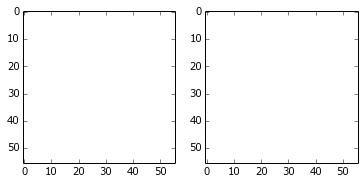

In [19]:
_, (ax1, ax2) = plt.subplots(1, 2)

id = 1103
img = dataset[id,:,:]
ax1.imshow(img.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys);
print labels[id]

id = 1104
img = dataset[id,:,:]
ax2.imshow(img.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.Greys);
print labels[id]

In [39]:
print "New shape", dataset.shape
print "New Labels:", labels.shape

New shape (10000, 56, 56, 1)
New Labels: (10000, 5)


# of digits: [2]
Labels: [ 5  1 -1 -1 -1]


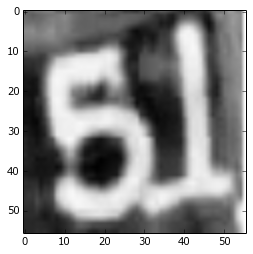

In [64]:
id = 9999
img = dataset[id]
# print img
plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap=plt.cm.Greys)
print "# of digits:", n_bboxes[id]
print "Labels:", labels[id]

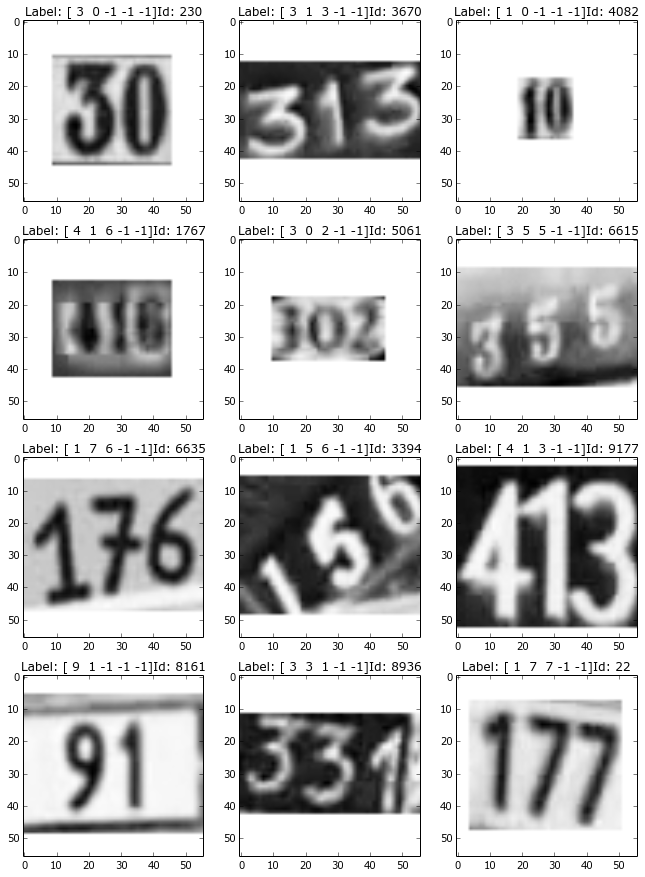

In [72]:
display_images_at_random(dataset, labels)

In [16]:
# valid_dataset = dataset[:VALIDATION_DATASET_SIZE]
# valid_labels = labels[:VALIDATION_DATASET_SIZE]

# test_dataset = dataset[VALIDATION_DATASET_SIZE:TEST_DATASET_SIZE]
# test_labels = labels[VALIDATION_DATASET_SIZE:TEST_DATASET_SIZE]

# train_dataset = dataset[TEST_DATASET_SIZE:]
# train_labels = labels[TEST_DATASET_SIZE:]

In [17]:
# print('Training set', train_dataset.shape, train_labels.shape)
# print('Validation set', valid_dataset.shape, valid_labels.shape)
# print('Test set', test_dataset.shape, test_labels.shape)

In [57]:

pickle_file = 'extra_10_dataset.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
     'extra_10_dataset': dataset,
     'extra_10_labels': labels,
     'extra_10_n_bboxes': n_bboxes,
#     'valid_labels': valid_labels,
#    'test_dataset': dataset,
#    'test_labels': labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise
print "Done"

Done


In [58]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 125799605
